In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.phi_files = [f for f in os.listdir(data_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.v_thresh_files = [f for f in os.listdir(data_dir) if f.startswith('v_thresh_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        # Load the input vector (phi)
        phi_file = os.path.join(self.data_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)

        # Load the output scalar (v_thresh)
        v_thresh_file = os.path.join(self.data_dir, self.v_thresh_files[idx])
        v_thresh = np.loadtxt(v_thresh_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(v_thresh, dtype=torch.float32)

In [2]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [3]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = (torch.sigmoid(self.fc3(x)) + 1)*0.5 # Busquem el rang (0.5, 1)
        return x

In [4]:
def evaluate_model(model, train_loader, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    losses_over_train = []
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            losses_over_train.append(loss.item())
    print(f'Train Loss: {total_loss / len(train_loader):.4f}')
    
    total_loss = 0.0
    losses_over_test = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            losses_over_test.append(loss.item())
    print(f'Test Loss: {total_loss / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0, leave=True)
        for i, (inputs, targets) in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        _, _ = evaluate_model(model, train_loader, test_loader, criterion)

In [5]:
data_dir = 'C:\\Users\\avp\\OneDrive - HKUST Connect\\Desktop\\Deep T-Rex\\Code\\RCode\\data'
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat_1.txt')))

hparams = {"batch_size": 16,
           "learning_rate": 0.01,
           "num_epochs": 10}

train_loader, test_loader = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"])

losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)

Epoch 1/100: 100%|██████████| 500/500 [00:03<00:00, 134.43it/s]


Epoch [1/100], Running Loss: 0.0261
Train Loss: 0.0194
Test Loss: 0.0199


Epoch 2/100: 100%|██████████| 500/500 [00:02<00:00, 181.39it/s]


Epoch [2/100], Running Loss: 0.0194
Train Loss: 0.0184
Test Loss: 0.0201


Epoch 3/100: 100%|██████████| 500/500 [00:02<00:00, 182.58it/s]


Epoch [3/100], Running Loss: 0.0185
Train Loss: 0.0166
Test Loss: 0.0171


Epoch 4/100: 100%|██████████| 500/500 [00:02<00:00, 193.34it/s]


Epoch [4/100], Running Loss: 0.0179
Train Loss: 0.0166
Test Loss: 0.0182


Epoch 5/100: 100%|██████████| 500/500 [00:02<00:00, 197.17it/s]


Epoch [5/100], Running Loss: 0.0175
Train Loss: 0.0161
Test Loss: 0.0165


Epoch 6/100: 100%|██████████| 500/500 [00:02<00:00, 192.02it/s]


Epoch [6/100], Running Loss: 0.0172
Train Loss: 0.0156
Test Loss: 0.0168


Epoch 7/100: 100%|██████████| 500/500 [00:02<00:00, 191.52it/s]


Epoch [7/100], Running Loss: 0.0170
Train Loss: 0.0155
Test Loss: 0.0170


Epoch 8/100: 100%|██████████| 500/500 [00:02<00:00, 195.97it/s]


Epoch [8/100], Running Loss: 0.0162
Train Loss: 0.0154
Test Loss: 0.0174


Epoch 9/100: 100%|██████████| 500/500 [00:02<00:00, 189.79it/s]


Epoch [9/100], Running Loss: 0.0161
Train Loss: 0.0151
Test Loss: 0.0176


Epoch 10/100: 100%|██████████| 500/500 [00:02<00:00, 191.54it/s]


Epoch [10/100], Running Loss: 0.0154
Train Loss: 0.0151
Test Loss: 0.0191


Epoch 11/100: 100%|██████████| 500/500 [00:02<00:00, 177.28it/s]


Epoch [11/100], Running Loss: 0.0149
Train Loss: 0.0142
Test Loss: 0.0183


Epoch 12/100: 100%|██████████| 500/500 [00:02<00:00, 197.40it/s]


Epoch [12/100], Running Loss: 0.0146
Train Loss: 0.0134
Test Loss: 0.0179


Epoch 13/100: 100%|██████████| 500/500 [00:02<00:00, 196.06it/s]


Epoch [13/100], Running Loss: 0.0139
Train Loss: 0.0127
Test Loss: 0.0183


Epoch 14/100: 100%|██████████| 500/500 [00:02<00:00, 196.14it/s]


Epoch [14/100], Running Loss: 0.0134
Train Loss: 0.0116
Test Loss: 0.0175


Epoch 15/100: 100%|██████████| 500/500 [00:02<00:00, 191.82it/s]


Epoch [15/100], Running Loss: 0.0124
Train Loss: 0.0111
Test Loss: 0.0179


Epoch 16/100: 100%|██████████| 500/500 [00:02<00:00, 192.44it/s]


Epoch [16/100], Running Loss: 0.0116
Train Loss: 0.0104
Test Loss: 0.0185


Epoch 17/100: 100%|██████████| 500/500 [00:02<00:00, 189.37it/s]


Epoch [17/100], Running Loss: 0.0111
Train Loss: 0.0093
Test Loss: 0.0185


Epoch 18/100: 100%|██████████| 500/500 [00:02<00:00, 196.81it/s]


Epoch [18/100], Running Loss: 0.0100
Train Loss: 0.0093
Test Loss: 0.0196


Epoch 19/100: 100%|██████████| 500/500 [00:02<00:00, 192.99it/s]


Epoch [19/100], Running Loss: 0.0095
Train Loss: 0.0081
Test Loss: 0.0188


Epoch 20/100: 100%|██████████| 500/500 [00:02<00:00, 182.01it/s]


Epoch [20/100], Running Loss: 0.0089
Train Loss: 0.0073
Test Loss: 0.0199


Epoch 21/100: 100%|██████████| 500/500 [00:02<00:00, 186.90it/s]


Epoch [21/100], Running Loss: 0.0081
Train Loss: 0.0071
Test Loss: 0.0209


Epoch 22/100: 100%|██████████| 500/500 [00:02<00:00, 195.69it/s]


Epoch [22/100], Running Loss: 0.0077
Train Loss: 0.0063
Test Loss: 0.0194


Epoch 23/100: 100%|██████████| 500/500 [00:02<00:00, 188.56it/s]


Epoch [23/100], Running Loss: 0.0073
Train Loss: 0.0067
Test Loss: 0.0204


Epoch 24/100: 100%|██████████| 500/500 [00:02<00:00, 203.69it/s]


Epoch [24/100], Running Loss: 0.0069
Train Loss: 0.0059
Test Loss: 0.0206


Epoch 25/100: 100%|██████████| 500/500 [00:02<00:00, 199.27it/s]


Epoch [25/100], Running Loss: 0.0063
Train Loss: 0.0055
Test Loss: 0.0212


Epoch 26/100: 100%|██████████| 500/500 [00:02<00:00, 194.79it/s]


Epoch [26/100], Running Loss: 0.0061
Train Loss: 0.0051
Test Loss: 0.0214


Epoch 27/100: 100%|██████████| 500/500 [00:02<00:00, 193.41it/s]


Epoch [27/100], Running Loss: 0.0056
Train Loss: 0.0054
Test Loss: 0.0217


Epoch 28/100: 100%|██████████| 500/500 [00:02<00:00, 179.18it/s]


Epoch [28/100], Running Loss: 0.0057
Train Loss: 0.0054
Test Loss: 0.0215


Epoch 29/100: 100%|██████████| 500/500 [00:02<00:00, 169.31it/s]


Epoch [29/100], Running Loss: 0.0053
Train Loss: 0.0048
Test Loss: 0.0214


Epoch 30/100: 100%|██████████| 500/500 [00:02<00:00, 195.12it/s]


Epoch [30/100], Running Loss: 0.0050
Train Loss: 0.0043
Test Loss: 0.0212


Epoch 31/100: 100%|██████████| 500/500 [00:02<00:00, 172.96it/s]


Epoch [31/100], Running Loss: 0.0050
Train Loss: 0.0042
Test Loss: 0.0219


Epoch 32/100: 100%|██████████| 500/500 [00:02<00:00, 179.95it/s]


Epoch [32/100], Running Loss: 0.0044
Train Loss: 0.0039
Test Loss: 0.0214


Epoch 33/100: 100%|██████████| 500/500 [00:02<00:00, 179.07it/s]


Epoch [33/100], Running Loss: 0.0045
Train Loss: 0.0041
Test Loss: 0.0223


Epoch 34/100: 100%|██████████| 500/500 [00:02<00:00, 169.43it/s]


Epoch [34/100], Running Loss: 0.0043
Train Loss: 0.0039
Test Loss: 0.0211


Epoch 35/100: 100%|██████████| 500/500 [00:03<00:00, 163.80it/s]


Epoch [35/100], Running Loss: 0.0043
Train Loss: 0.0040
Test Loss: 0.0229


Epoch 36/100: 100%|██████████| 500/500 [00:02<00:00, 177.24it/s]


Epoch [36/100], Running Loss: 0.0041
Train Loss: 0.0040
Test Loss: 0.0228


Epoch 37/100: 100%|██████████| 500/500 [00:02<00:00, 185.96it/s]


Epoch [37/100], Running Loss: 0.0039
Train Loss: 0.0039
Test Loss: 0.0219


Epoch 38/100: 100%|██████████| 500/500 [00:03<00:00, 164.34it/s]


Epoch [38/100], Running Loss: 0.0042
Train Loss: 0.0033
Test Loss: 0.0226


Epoch 39/100: 100%|██████████| 500/500 [00:02<00:00, 171.80it/s]


Epoch [39/100], Running Loss: 0.0037
Train Loss: 0.0033
Test Loss: 0.0228


Epoch 40/100: 100%|██████████| 500/500 [00:02<00:00, 173.20it/s]


Epoch [40/100], Running Loss: 0.0037
Train Loss: 0.0032
Test Loss: 0.0232


Epoch 41/100: 100%|██████████| 500/500 [00:02<00:00, 186.02it/s]


Epoch [41/100], Running Loss: 0.0036
Train Loss: 0.0032
Test Loss: 0.0228


Epoch 42/100: 100%|██████████| 500/500 [00:02<00:00, 170.57it/s]


Epoch [42/100], Running Loss: 0.0037
Train Loss: 0.0033
Test Loss: 0.0234


Epoch 43/100: 100%|██████████| 500/500 [00:02<00:00, 193.46it/s]


Epoch [43/100], Running Loss: 0.0035
Train Loss: 0.0031
Test Loss: 0.0223


Epoch 44/100: 100%|██████████| 500/500 [00:02<00:00, 194.34it/s]


Epoch [44/100], Running Loss: 0.0035
Train Loss: 0.0029
Test Loss: 0.0223


Epoch 45/100: 100%|██████████| 500/500 [00:03<00:00, 160.49it/s]


Epoch [45/100], Running Loss: 0.0033
Train Loss: 0.0030
Test Loss: 0.0216


Epoch 46/100: 100%|██████████| 500/500 [00:02<00:00, 193.35it/s]


Epoch [46/100], Running Loss: 0.0032
Train Loss: 0.0029
Test Loss: 0.0231


Epoch 47/100: 100%|██████████| 500/500 [00:02<00:00, 167.82it/s]


Epoch [47/100], Running Loss: 0.0031
Train Loss: 0.0030
Test Loss: 0.0230


Epoch 48/100: 100%|██████████| 500/500 [00:02<00:00, 184.39it/s]


Epoch [48/100], Running Loss: 0.0032
Train Loss: 0.0032
Test Loss: 0.0242


Epoch 49/100: 100%|██████████| 500/500 [00:02<00:00, 190.44it/s]


Epoch [49/100], Running Loss: 0.0031
Train Loss: 0.0030
Test Loss: 0.0233


Epoch 50/100: 100%|██████████| 500/500 [00:02<00:00, 188.24it/s]


Epoch [50/100], Running Loss: 0.0031
Train Loss: 0.0029
Test Loss: 0.0232


Epoch 51/100: 100%|██████████| 500/500 [00:03<00:00, 162.13it/s]


Epoch [51/100], Running Loss: 0.0031
Train Loss: 0.0030
Test Loss: 0.0233


Epoch 52/100: 100%|██████████| 500/500 [00:03<00:00, 153.95it/s]


Epoch [52/100], Running Loss: 0.0031
Train Loss: 0.0028
Test Loss: 0.0235


Epoch 53/100: 100%|██████████| 500/500 [00:02<00:00, 189.46it/s]


Epoch [53/100], Running Loss: 0.0030
Train Loss: 0.0027
Test Loss: 0.0227


Epoch 54/100: 100%|██████████| 500/500 [00:02<00:00, 194.29it/s]


Epoch [54/100], Running Loss: 0.0029
Train Loss: 0.0031
Test Loss: 0.0224


Epoch 55/100: 100%|██████████| 500/500 [00:02<00:00, 198.97it/s]


Epoch [55/100], Running Loss: 0.0030
Train Loss: 0.0026
Test Loss: 0.0226


Epoch 56/100: 100%|██████████| 500/500 [00:02<00:00, 190.99it/s]


Epoch [56/100], Running Loss: 0.0029
Train Loss: 0.0028
Test Loss: 0.0233


Epoch 57/100: 100%|██████████| 500/500 [00:02<00:00, 168.51it/s]


Epoch [57/100], Running Loss: 0.0029
Train Loss: 0.0026
Test Loss: 0.0230


Epoch 58/100: 100%|██████████| 500/500 [00:02<00:00, 189.16it/s]


Epoch [58/100], Running Loss: 0.0028
Train Loss: 0.0022
Test Loss: 0.0229


Epoch 59/100: 100%|██████████| 500/500 [00:02<00:00, 192.35it/s]


Epoch [59/100], Running Loss: 0.0027
Train Loss: 0.0025
Test Loss: 0.0234


Epoch 60/100: 100%|██████████| 500/500 [00:02<00:00, 178.02it/s]


Epoch [60/100], Running Loss: 0.0028
Train Loss: 0.0023
Test Loss: 0.0229


Epoch 61/100: 100%|██████████| 500/500 [00:02<00:00, 189.74it/s]


Epoch [61/100], Running Loss: 0.0026
Train Loss: 0.0024
Test Loss: 0.0231


Epoch 62/100: 100%|██████████| 500/500 [00:02<00:00, 176.35it/s]


Epoch [62/100], Running Loss: 0.0027
Train Loss: 0.0024
Test Loss: 0.0225


Epoch 63/100: 100%|██████████| 500/500 [00:02<00:00, 175.46it/s]


Epoch [63/100], Running Loss: 0.0026
Train Loss: 0.0026
Test Loss: 0.0232


Epoch 64/100: 100%|██████████| 500/500 [00:02<00:00, 177.60it/s]


Epoch [64/100], Running Loss: 0.0026
Train Loss: 0.0025
Test Loss: 0.0221


Epoch 65/100: 100%|██████████| 500/500 [00:02<00:00, 178.45it/s]


Epoch [65/100], Running Loss: 0.0025
Train Loss: 0.0025
Test Loss: 0.0228


Epoch 66/100: 100%|██████████| 500/500 [00:02<00:00, 177.99it/s]


Epoch [66/100], Running Loss: 0.0024
Train Loss: 0.0022
Test Loss: 0.0231


Epoch 67/100: 100%|██████████| 500/500 [00:02<00:00, 196.20it/s]


Epoch [67/100], Running Loss: 0.0025
Train Loss: 0.0022
Test Loss: 0.0234


Epoch 68/100: 100%|██████████| 500/500 [00:02<00:00, 190.95it/s]


Epoch [68/100], Running Loss: 0.0026
Train Loss: 0.0026
Test Loss: 0.0230


Epoch 69/100: 100%|██████████| 500/500 [00:02<00:00, 190.13it/s]


Epoch [69/100], Running Loss: 0.0027
Train Loss: 0.0023
Test Loss: 0.0226


Epoch 70/100: 100%|██████████| 500/500 [00:02<00:00, 189.72it/s]


Epoch [70/100], Running Loss: 0.0023
Train Loss: 0.0021
Test Loss: 0.0223


Epoch 71/100: 100%|██████████| 500/500 [00:02<00:00, 178.51it/s]


Epoch [71/100], Running Loss: 0.0023
Train Loss: 0.0020
Test Loss: 0.0227


Epoch 72/100: 100%|██████████| 500/500 [00:02<00:00, 179.11it/s]


Epoch [72/100], Running Loss: 0.0023
Train Loss: 0.0021
Test Loss: 0.0233


Epoch 73/100: 100%|██████████| 500/500 [00:03<00:00, 163.95it/s]


Epoch [73/100], Running Loss: 0.0023
Train Loss: 0.0022
Test Loss: 0.0228


Epoch 74/100: 100%|██████████| 500/500 [00:02<00:00, 174.62it/s]


Epoch [74/100], Running Loss: 0.0024
Train Loss: 0.0023
Test Loss: 0.0234


Epoch 75/100: 100%|██████████| 500/500 [00:02<00:00, 183.55it/s]


Epoch [75/100], Running Loss: 0.0027
Train Loss: 0.0024
Test Loss: 0.0231


Epoch 76/100: 100%|██████████| 500/500 [00:02<00:00, 181.23it/s]


Epoch [76/100], Running Loss: 0.0024
Train Loss: 0.0019
Test Loss: 0.0229


Epoch 77/100: 100%|██████████| 500/500 [00:02<00:00, 170.82it/s]


Epoch [77/100], Running Loss: 0.0021
Train Loss: 0.0020
Test Loss: 0.0232


Epoch 78/100: 100%|██████████| 500/500 [00:02<00:00, 181.47it/s]


Epoch [78/100], Running Loss: 0.0024
Train Loss: 0.0020
Test Loss: 0.0222


Epoch 79/100: 100%|██████████| 500/500 [00:03<00:00, 148.27it/s]


Epoch [79/100], Running Loss: 0.0024
Train Loss: 0.0021
Test Loss: 0.0230


Epoch 80/100: 100%|██████████| 500/500 [00:02<00:00, 196.33it/s]


Epoch [80/100], Running Loss: 0.0023
Train Loss: 0.0021
Test Loss: 0.0235


Epoch 81/100: 100%|██████████| 500/500 [00:02<00:00, 170.55it/s]


Epoch [81/100], Running Loss: 0.0024
Train Loss: 0.0021
Test Loss: 0.0233


Epoch 82/100: 100%|██████████| 500/500 [00:03<00:00, 152.17it/s]


Epoch [82/100], Running Loss: 0.0023
Train Loss: 0.0021
Test Loss: 0.0236


Epoch 83/100: 100%|██████████| 500/500 [00:03<00:00, 164.49it/s]


Epoch [83/100], Running Loss: 0.0022
Train Loss: 0.0019
Test Loss: 0.0238


Epoch 84/100: 100%|██████████| 500/500 [00:02<00:00, 187.32it/s]


Epoch [84/100], Running Loss: 0.0021
Train Loss: 0.0018
Test Loss: 0.0237


Epoch 85/100: 100%|██████████| 500/500 [00:02<00:00, 185.91it/s]


Epoch [85/100], Running Loss: 0.0020
Train Loss: 0.0022
Test Loss: 0.0237


Epoch 86/100: 100%|██████████| 500/500 [00:02<00:00, 178.92it/s]


Epoch [86/100], Running Loss: 0.0023
Train Loss: 0.0020
Test Loss: 0.0235


Epoch 87/100: 100%|██████████| 500/500 [00:02<00:00, 193.28it/s]


Epoch [87/100], Running Loss: 0.0023
Train Loss: 0.0022
Test Loss: 0.0248


Epoch 88/100: 100%|██████████| 500/500 [00:02<00:00, 183.27it/s]


Epoch [88/100], Running Loss: 0.0021
Train Loss: 0.0019
Test Loss: 0.0241


Epoch 89/100: 100%|██████████| 500/500 [00:02<00:00, 189.90it/s]


Epoch [89/100], Running Loss: 0.0021
Train Loss: 0.0020
Test Loss: 0.0241


Epoch 90/100: 100%|██████████| 500/500 [00:03<00:00, 159.89it/s]


Epoch [90/100], Running Loss: 0.0021
Train Loss: 0.0019
Test Loss: 0.0238


Epoch 91/100: 100%|██████████| 500/500 [00:02<00:00, 201.90it/s]


Epoch [91/100], Running Loss: 0.0023
Train Loss: 0.0020
Test Loss: 0.0229


Epoch 92/100: 100%|██████████| 500/500 [00:02<00:00, 198.99it/s]


Epoch [92/100], Running Loss: 0.0021
Train Loss: 0.0018
Test Loss: 0.0234


Epoch 93/100: 100%|██████████| 500/500 [00:02<00:00, 196.58it/s]


Epoch [93/100], Running Loss: 0.0020
Train Loss: 0.0019
Test Loss: 0.0229


Epoch 94/100: 100%|██████████| 500/500 [00:02<00:00, 191.49it/s]


Epoch [94/100], Running Loss: 0.0020
Train Loss: 0.0022
Test Loss: 0.0256


Epoch 95/100: 100%|██████████| 500/500 [00:02<00:00, 202.19it/s]


Epoch [95/100], Running Loss: 0.0021
Train Loss: 0.0022
Test Loss: 0.0255


Epoch 96/100: 100%|██████████| 500/500 [00:02<00:00, 191.12it/s]


Epoch [96/100], Running Loss: 0.0021
Train Loss: 0.0017
Test Loss: 0.0236


Epoch 97/100: 100%|██████████| 500/500 [00:02<00:00, 202.43it/s]


Epoch [97/100], Running Loss: 0.0020
Train Loss: 0.0019
Test Loss: 0.0246


Epoch 98/100: 100%|██████████| 500/500 [00:02<00:00, 203.76it/s]


Epoch [98/100], Running Loss: 0.0021
Train Loss: 0.0021
Test Loss: 0.0243


Epoch 99/100: 100%|██████████| 500/500 [00:02<00:00, 203.07it/s]


Epoch [99/100], Running Loss: 0.0020
Train Loss: 0.0018
Test Loss: 0.0242


Epoch 100/100: 100%|██████████| 500/500 [00:02<00:00, 204.36it/s]


Epoch [100/100], Running Loss: 0.0020
Train Loss: 0.0019
Test Loss: 0.0245
Train Loss: 0.0019
Test Loss: 0.0245


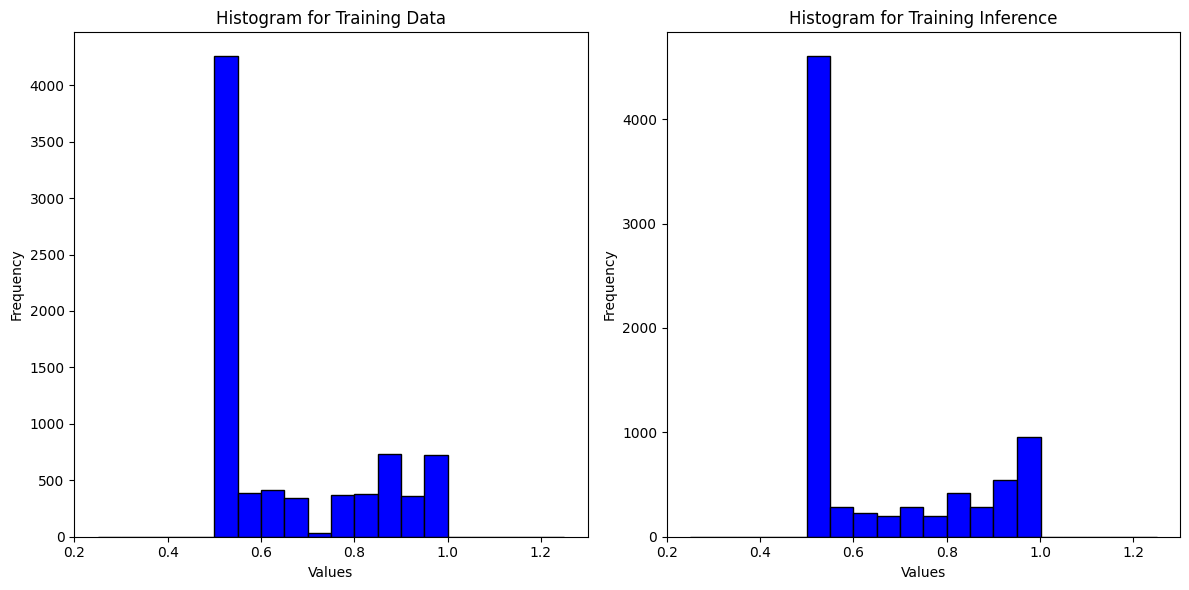

In [12]:
model.eval()

with torch.no_grad():
    total_train_loader = []
    for inputs, targets in train_loader:
        total_train_loader += targets.numpy().squeeze().tolist()
    
    total_train = []
    for inputs, targets in train_loader:
        total_train += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(total_train_loader, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(total_train, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

(array([ 8., 17., 23., 41., 44., 66., 58., 62., 56., 47., 24., 17.,  4.,
         8., 10.,  3.,  2.,  4.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.]),
 array([0.01091383, 0.01502336, 0.0191329 , 0.02324243, 0.02735197,
        0.0314615 , 0.03557104, 0.03968057, 0.04379011, 0.04789964,
        0.05200917, 0.05611871, 0.06022824, 0.06433778, 0.06844731,
        0.07255685, 0.07666638, 0.08077591, 0.08488545, 0.08899498,
        0.09310452, 0.09721405, 0.10132359, 0.10543312, 0.10954265,
        0.11365219, 0.11776172, 0.12187126, 0.12598079, 0.13009033,
        0.13419986, 0.13830939]),
 <BarContainer object of 31 artists>)

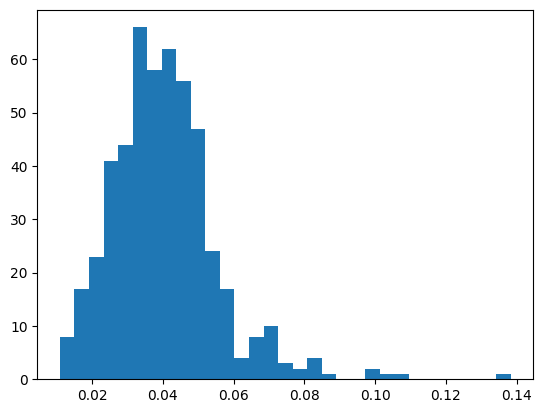

In [13]:
plt.hist(np.sqrt(losses_over_train), bins='auto')

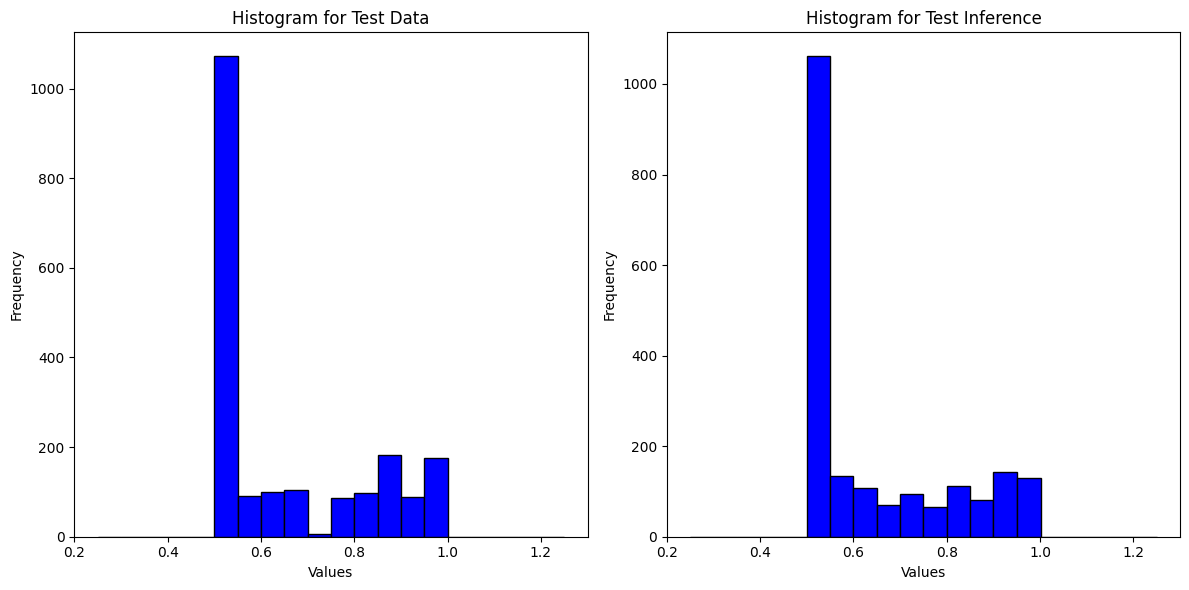

In [14]:
model.eval()

with torch.no_grad():
    total_test_loader = []
    for inputs, targets in test_loader:
        total_test_loader += targets.numpy().squeeze().tolist()
    
    total_test = []
    for inputs, targets in test_loader:
        total_test += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(total_test_loader, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(total_test, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

(array([ 2.,  6., 13., 17., 19., 32., 16., 14.,  6.]),
 array([0.05251228, 0.07244115, 0.09237003, 0.11229891, 0.13222778,
        0.15215666, 0.17208554, 0.19201441, 0.21194329, 0.23187216]),
 <BarContainer object of 9 artists>)

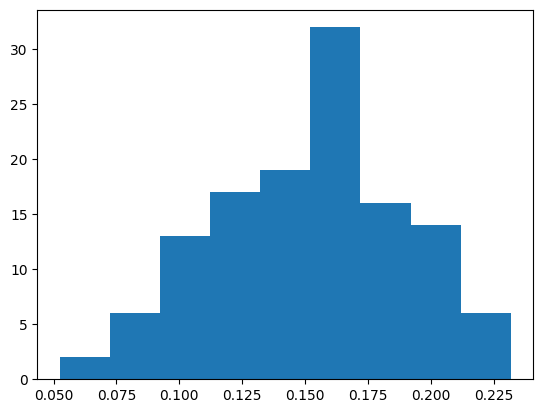

In [15]:
plt.hist(np.sqrt(losses_over_test), bins='auto')